In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error, auc, roc_curve
pd.set_option("display.max_rows", None, "display.max_columns", None)
import math
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from scipy.stats import pointbiserialr
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from sklearn.preprocessing import RobustScaler
from sklearn import metrics

In [2]:
data=pd.read_csv("train.csv")

In [3]:
test_data=pd.read_csv("test.csv")

In [4]:
data.dtypes

ID                    int64
CHK_ACCT              int64
DURATION              int64
HISTORY               int64
NEW_CAR               int64
USED_CAR              int64
FURNITURE             int64
RADIO_TV              int64
EDUCATION           float64
RETRAINING            int64
AMOUNT              float64
SAV_ACCT              int64
EMPLOYMENT            int64
INSTALL_RATE          int64
MALE_DIV              int64
MALE_SINGLE           int64
MALE_MAR_or_WID       int64
CO_APPLICANT          int64
GUARANTOR             int64
PRESENT_RESIDENT      int64
REAL_ESTATE           int64
PROP_UNKN_NONE        int64
AGE                   int64
OTHER_INSTALL         int64
RENT                float64
OWN_RES               int64
NUM_CREDITS           int64
JOB                 float64
NUM_DEPENDENTS        int64
TELEPHONE             int64
FOREIGN               int64
RESPONSE              int64
dtype: object

In [5]:
#examine missing values
data.isnull().sum()
#since there are not too many missing values, we can remove rows(observations) with the missing values
data=data.dropna()

In [6]:
data=data.drop('ID',axis=1)

In [7]:
data = data.astype({"JOB": int, "EDUCATION": int})

<AxesSubplot:>

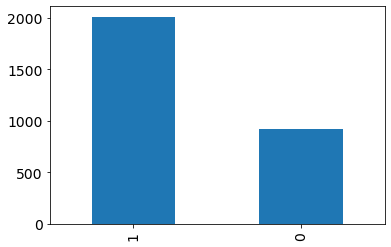

In [8]:
#IS OUR DATA BALANCED? (APPLYING REBALANCING LATER ON)
data["RESPONSE"].value_counts()
data['RESPONSE'].value_counts().plot(kind="bar")

(array([  61.,    0.,    0.,  579.,    0.,    0., 1838.,    0.,    0.,
         453.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

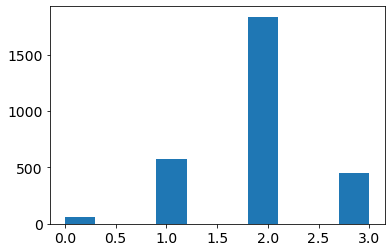

In [9]:
plt.hist(data.JOB)

In [10]:
continuous_variables = ['DURATION', 'AMOUNT', 'AGE','NUM_CREDITS','NUM_DEPENDENTS']

In [11]:
categoricals= ",".join(data.drop(['RESPONSE','DURATION', 'AMOUNT', 'AGE','NUM_CREDITS','NUM_DEPENDENTS'],axis=1).columns)

In [12]:
categoricals

'CHK_ACCT,HISTORY,NEW_CAR,USED_CAR,FURNITURE,RADIO_TV,EDUCATION,RETRAINING,SAV_ACCT,EMPLOYMENT,INSTALL_RATE,MALE_DIV,MALE_SINGLE,MALE_MAR_or_WID,CO_APPLICANT,GUARANTOR,PRESENT_RESIDENT,REAL_ESTATE,PROP_UNKN_NONE,OTHER_INSTALL,RENT,OWN_RES,JOB,TELEPHONE,FOREIGN'

In [13]:
categorical_variables=['CHK_ACCT','HISTORY','NEW_CAR','USED_CAR','FURNITURE','RADIO_TV','EDUCATION','RETRAINING','SAV_ACCT','EMPLOYMENT','INSTALL_RATE','MALE_DIV','MALE_SINGLE','MALE_MAR_or_WID','CO_APPLICANT','GUARANTOR','PRESENT_RESIDENT','REAL_ESTATE','PROP_UNKN_NONE','OTHER_INSTALL','RENT','OWN_RES','JOB','TELEPHONE','FOREIGN']

In [14]:
# The following function generates the formula to input into the statsmodel function, 
# with specified predictors(columns) removed.
droplist = ['RESPONSE']

def remove_name_formula(toremove):
    print(type(toremove))
    global droplist
    droplist = droplist+toremove
    newdf = data.drop(droplist,axis=1)
    predictors = "+".join(newdf.columns)
    f = 'RESPONSE ~ '+predictors
    return f

In [15]:
#relation between categorical and continuous

# Find Point biserial correlation
for cat_var in categorical_variables:
  for cont_var in continuous_variables:
    data_cat = data[cat_var].to_numpy()
    data_cont = data[cont_var].to_numpy()
    
    corr, p_val = pointbiserialr(x=data_cat,y=data_cont)
    if np.abs(corr) >= 0.7:
      print(f'Categorical variable: {cat_var}, Continuous variable: {cont_var}, correlation: {corr}')

In [16]:
# Find Pearson correlation(for continuous variables)
total_len = len(continuous_variables)
for idx1 in range(total_len-1):
  for idx2 in range(idx1+1, total_len):
    cont_var1 = continuous_variables[idx1]
    cont_var2 = continuous_variables[idx2]
    data_cont1 = data[cont_var1].to_numpy()
    data_cont2 = data[cont_var2].to_numpy()
    corr, p_val = pearsonr(x=data_cont1, y=data_cont2)
    if np.abs(corr) >= 0.7:
      print(f'Variable 1: {cont_var1}, Variable 2: {cont_var2}, correlation: {corr}')

In [17]:
# Find Cramer's V correlation
total_len = len(categorical_variables)
for idx1 in range(total_len-1):
  for idx2 in range(idx1+1, total_len):
    cat_var1 = categorical_variables[idx1]
    cat_var2 = categorical_variables[idx2]    
    c_matrix = pd.crosstab(data[cat_var1], data[cat_var2])
    chi2 = chi2_contingency(c_matrix)[0]
    n = c_matrix.sum().sum()
    phi2 = chi2/n
    r,k = c_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    corr = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
    if corr >= 0.7:
      print(f'categorical variable 1 {cat_var1}, categorical variable 2: {cat_var2}, correlation: {corr}')

Exploratory Data Analysis

In [18]:
#all predictors
all_predictors='+'.join(data.drop(['RESPONSE'],axis=1).columns)
print(all_predictors)

CHK_ACCT+DURATION+HISTORY+NEW_CAR+USED_CAR+FURNITURE+RADIO_TV+EDUCATION+RETRAINING+AMOUNT+SAV_ACCT+EMPLOYMENT+INSTALL_RATE+MALE_DIV+MALE_SINGLE+MALE_MAR_or_WID+CO_APPLICANT+GUARANTOR+PRESENT_RESIDENT+REAL_ESTATE+PROP_UNKN_NONE+AGE+OTHER_INSTALL+RENT+OWN_RES+NUM_CREDITS+JOB+NUM_DEPENDENTS+TELEPHONE+FOREIGN


In [19]:
f = 'RESPONSE~'+ all_predictors
f

'RESPONSE~CHK_ACCT+DURATION+HISTORY+NEW_CAR+USED_CAR+FURNITURE+RADIO_TV+EDUCATION+RETRAINING+AMOUNT+SAV_ACCT+EMPLOYMENT+INSTALL_RATE+MALE_DIV+MALE_SINGLE+MALE_MAR_or_WID+CO_APPLICANT+GUARANTOR+PRESENT_RESIDENT+REAL_ESTATE+PROP_UNKN_NONE+AGE+OTHER_INSTALL+RENT+OWN_RES+NUM_CREDITS+JOB+NUM_DEPENDENTS+TELEPHONE+FOREIGN'

## First method of doing feature selection using logistic regression


In [20]:
#fit logistic regression model
logitfit = smf.logit(formula = f, data = data).fit()
print(logitfit.summary())

Optimization terminated successfully.
         Current function value: 0.555637
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RESPONSE   No. Observations:                 2931
Model:                          Logit   Df Residuals:                     2900
Method:                           MLE   Df Model:                           30
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.1073
Time:                        17:06:09   Log-Likelihood:                -1628.6
converged:                       True   LL-Null:                       -1824.4
Covariance Type:            nonrobust   LLR p-value:                 1.383e-64
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3229      0.317     -1.018      0.309      -0.945       0.299
CHK_ACCT   

In [21]:
#looking at the p-values we see that not all variables may be significant
#Highest p-value comes from furniture so we can try removing that

f = remove_name_formula(['FURNITURE'])
logitfit = smf.logit(formula = f, data = data).fit()
print(logitfit.summary())



<class 'list'>
Optimization terminated successfully.
         Current function value: 0.555640
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RESPONSE   No. Observations:                 2931
Model:                          Logit   Df Residuals:                     2901
Method:                           MLE   Df Model:                           29
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.1073
Time:                        17:06:09   Log-Likelihood:                -1628.6
converged:                       True   LL-Null:                       -1824.4
Covariance Type:            nonrobust   LLR p-value:                 3.750e-65
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3294      0.313     -1.051      0.293      -0.944       0.

In [22]:
f = remove_name_formula(['MALE_MAR_or_WID'])
logitfit = smf.logit(formula = f, data = data).fit()
print(logitfit.summary())


<class 'list'>
Optimization terminated successfully.
         Current function value: 0.555645
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RESPONSE   No. Observations:                 2931
Model:                          Logit   Df Residuals:                     2902
Method:                           MLE   Df Model:                           28
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.1073
Time:                        17:06:10   Log-Likelihood:                -1628.6
converged:                       True   LL-Null:                       -1824.4
Covariance Type:            nonrobust   LLR p-value:                 1.006e-65
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3382      0.310     -1.093      0.275      -0.945       0.

In [23]:
f = remove_name_formula(['NEW_CAR'])
logitfit = smf.logit(formula = f, data = data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.555655
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RESPONSE   No. Observations:                 2931
Model:                          Logit   Df Residuals:                     2903
Method:                           MLE   Df Model:                           27
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.1073
Time:                        17:06:10   Log-Likelihood:                -1628.6
converged:                       True   LL-Null:                       -1824.4
Covariance Type:            nonrobust   LLR p-value:                 2.684e-66
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3293      0.307     -1.071      0.284      -0.932       0.

In [24]:
f = remove_name_formula(['PRESENT_RESIDENT'])
logitfit = smf.logit(formula = f, data = data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.555701
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RESPONSE   No. Observations:                 2931
Model:                          Logit   Df Residuals:                     2904
Method:                           MLE   Df Model:                           26
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.1072
Time:                        17:06:10   Log-Likelihood:                -1628.8
converged:                       True   LL-Null:                       -1824.4
Covariance Type:            nonrobust   LLR p-value:                 7.752e-67
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3814      0.291     -1.313      0.189      -0.951       0.188
CH

In [25]:
f = remove_name_formula(['MALE_DIV'])
logitfit = smf.logit(formula = f, data = data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.555752
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RESPONSE   No. Observations:                 2931
Model:                          Logit   Df Residuals:                     2905
Method:                           MLE   Df Model:                           25
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.1071
Time:                        17:06:10   Log-Likelihood:                -1628.9
converged:                       True   LL-Null:                       -1824.4
Covariance Type:            nonrobust   LLR p-value:                 2.224e-67
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3956      0.289     -1.367      0.172      -0.963       0.171
CH

In [26]:
f = remove_name_formula(['EDUCATION'])
logitfit = smf.logit(formula = f, data = data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.555838
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RESPONSE   No. Observations:                 2931
Model:                          Logit   Df Residuals:                     2906
Method:                           MLE   Df Model:                           24
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.1070
Time:                        17:06:10   Log-Likelihood:                -1629.2
converged:                       True   LL-Null:                       -1824.4
Covariance Type:            nonrobust   LLR p-value:                 6.908e-68
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3898      0.289     -1.347      0.178      -0.957       0.177
CH

In [27]:
f = remove_name_formula(['CO_APPLICANT'])
logitfit = smf.logit(formula = f, data = data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.555932
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RESPONSE   No. Observations:                 2931
Model:                          Logit   Df Residuals:                     2907
Method:                           MLE   Df Model:                           23
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.1069
Time:                        17:06:10   Log-Likelihood:                -1629.4
converged:                       True   LL-Null:                       -1824.4
Covariance Type:            nonrobust   LLR p-value:                 2.144e-68
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.4052      0.289     -1.404      0.160      -0.971       0.160
CH

In [28]:
f = remove_name_formula(['NUM_DEPENDENTS'])
logitfit = smf.logit(formula = f, data = data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.556042
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RESPONSE   No. Observations:                 2931
Model:                          Logit   Df Residuals:                     2908
Method:                           MLE   Df Model:                           22
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.1067
Time:                        17:06:10   Log-Likelihood:                -1629.8
converged:                       True   LL-Null:                       -1824.4
Covariance Type:            nonrobust   LLR p-value:                 6.816e-69
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5163      0.253     -2.037      0.042      -1.013      -0.020
CH

In [29]:
f = remove_name_formula(['RETRAINING'])
logitfit = smf.logit(formula = f, data = data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.556152
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RESPONSE   No. Observations:                 2931
Model:                          Logit   Df Residuals:                     2909
Method:                           MLE   Df Model:                           21
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.1065
Time:                        17:06:10   Log-Likelihood:                -1630.1
converged:                       True   LL-Null:                       -1824.4
Covariance Type:            nonrobust   LLR p-value:                 2.125e-69
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5209      0.253     -2.056      0.040      -1.017      -0.024
CH

In [30]:
f = remove_name_formula(['AGE'])
logitfit = smf.logit(formula = f, data = data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.556296
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RESPONSE   No. Observations:                 2931
Model:                          Logit   Df Residuals:                     2910
Method:                           MLE   Df Model:                           20
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.1063
Time:                        17:06:10   Log-Likelihood:                -1630.5
converged:                       True   LL-Null:                       -1824.4
Covariance Type:            nonrobust   LLR p-value:                 7.087e-70
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5068      0.253     -2.006      0.045      -1.002      -0.012
CH

In [31]:
f = remove_name_formula(['AMOUNT'])
logitfit = smf.logit(formula = f, data = data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.556477
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RESPONSE   No. Observations:                 2931
Model:                          Logit   Df Residuals:                     2911
Method:                           MLE   Df Model:                           19
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.1060
Time:                        17:06:10   Log-Likelihood:                -1631.0
converged:                       True   LL-Null:                       -1824.4
Covariance Type:            nonrobust   LLR p-value:                 2.567e-70
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5042      0.253     -1.995      0.046      -0.999      -0.009
CH

In [32]:
f = remove_name_formula(['NUM_CREDITS'])
logitfit = smf.logit(formula = f, data = data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.556834
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RESPONSE   No. Observations:                 2931
Model:                          Logit   Df Residuals:                     2912
Method:                           MLE   Df Model:                           18
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.1054
Time:                        17:06:10   Log-Likelihood:                -1632.1
converged:                       True   LL-Null:                       -1824.4
Covariance Type:            nonrobust   LLR p-value:                 1.485e-70
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3785      0.237     -1.600      0.110      -0.842       0.085
CH

In [33]:
f = remove_name_formula(['TELEPHONE'])
logitfit = smf.logit(formula = f, data = data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.557439
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RESPONSE   No. Observations:                 2931
Model:                          Logit   Df Residuals:                     2913
Method:                           MLE   Df Model:                           17
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.1044
Time:                        17:06:10   Log-Likelihood:                -1633.9
converged:                       True   LL-Null:                       -1824.4
Covariance Type:            nonrobust   LLR p-value:                 1.687e-70
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3761      0.236     -1.592      0.111      -0.839       0.087
CH

In [34]:
f = remove_name_formula(['FOREIGN'])
logitfit = smf.logit(formula = f, data = data).fit()
print(logitfit.summary())

<class 'list'>
Optimization terminated successfully.
         Current function value: 0.558060
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               RESPONSE   No. Observations:                 2931
Model:                          Logit   Df Residuals:                     2914
Method:                           MLE   Df Model:                           16
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.1034
Time:                        17:06:11   Log-Likelihood:                -1635.7
converged:                       True   LL-Null:                       -1824.4
Covariance Type:            nonrobust   LLR p-value:                 1.961e-70
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3351      0.235     -1.425      0.154      -0.796       0.126
CH

In [35]:
logitfit

In [36]:
f

'RESPONSE ~ CHK_ACCT+DURATION+HISTORY+USED_CAR+RADIO_TV+SAV_ACCT+EMPLOYMENT+INSTALL_RATE+MALE_SINGLE+GUARANTOR+REAL_ESTATE+PROP_UNKN_NONE+OTHER_INSTALL+RENT+OWN_RES+JOB'

In [37]:
#Train and test split and scaling
from sklearn.preprocessing import RobustScaler
Y = data['RESPONSE']
X = data[['CHK_ACCT','DURATION','HISTORY','USED_CAR','RADIO_TV','SAV_ACCT','EMPLOYMENT','INSTALL_RATE','MALE_SINGLE','GUARANTOR','REAL_ESTATE','PROP_UNKN_NONE','OTHER_INSTALL','RENT','OWN_RES','JOB']]
robust_scaler=RobustScaler()
X=robust_scaler.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=.20)

In [38]:
#features that we are going to use
features =['CHK_ACCT','DURATION','HISTORY','USED_CAR','RADIO_TV','SAV_ACCT','EMPLOYMENT','INSTALL_RATE','MALE_SINGLE','GUARANTOR','REAL_ESTATE','PROP_UNKN_NONE','OTHER_INSTALL','RENT','OWN_RES','JOB']

In [39]:
#simply balancing our X_train(now becomes X_res) and y_train(y_res)
import collections
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
x_res, y_res = over_sampler.fit_resample(x_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({1: 1599, 0: 1599})
Testing target statistics: Counter({1: 411, 0: 176})


In [40]:
classifier = LogisticRegression(random_state = 0)

In [41]:
#Hyperparameter tuning
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]
from sklearn.model_selection import GridSearchCV
clf=GridSearchCV(classifier,param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_clf = clf.fit(X,Y)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.31422723 ...        nan 0.70965541 0.70965541]
  warnings.warn(


In [42]:
best_clf.best_estimator_

LogisticRegression(C=0.23357214690901212, random_state=0, solver='liblinear')

In [43]:
classifier=LogisticRegression(C=0.23357214690901212, random_state=0, solver='liblinear')

In [44]:
classifier.fit(x_train, y_train)

LogisticRegression(C=0.23357214690901212, random_state=0, solver='liblinear')

In [45]:
y_pred_probabilities = classifier.predict_proba(x_test)
y_pred=classifier.predict(x_test)

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[ 46 130]
 [ 42 369]]


In [47]:
#evaluation metrics
from sklearn.metrics import accuracy_score
print ("Accuracy : ", accuracy_score(y_test, y_pred))
# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test,y_pred))
print("F1:",metrics.f1_score(y_test,y_pred))
print("precision:",metrics.precision_score(y_test,y_pred))


Accuracy :  0.706984667802385
Recall: 0.8978102189781022
F1: 0.810989010989011
precision: 0.7394789579158316


Quick description of the evaluation metrics:
High recall means a low false negative rate(where there is lesser number of people whom we classify as not defaulting when they actually default. (This is important for our problem set)

In [48]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
 
# Print the evaluation metrics as pandas dataframe
score = pd.DataFrame({"ROC-AUC" : [metrics.auc(fpr, tpr)]})
print(score)

    ROC-AUC
0  0.579587


## Second Method of doing feature selection using recursive feature elimination using logistic regression


In [49]:
data.shape

(2931, 31)

In [50]:
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
X = data.drop('RESPONSE',axis=1)
Y = data['RESPONSE']
robust_scaler=RobustScaler()
X = pd.DataFrame(robust_scaler.fit_transform(X), columns = X.columns)
#robust_scaler=RobustScaler()
#X=robust_scaler.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=.20)
#balance our dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_train, y_train)


In [51]:
classifier = LogisticRegression(random_state = 0)
rfe = RFECV(estimator=classifier, step=10, cv=KFold(n_splits=5, shuffle=False), scoring='roc_auc', verbose=2)

In [52]:
rfe.fit(X,Y)

Fitting estimator with 30 features.
Fitting estimator with 20 features.
Fitting estimator with 10 features.
Fitting estimator with 30 features.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Fitting estimator with 20 features.
Fitting estimator with 10 features.
Fitting estimator with 30 features.
Fitting estimator with 20 features.
Fitting estimator with 10 features.
Fitting estimator with 30 features.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Fitting estimator with 20 features.
Fitting estimator with 10 features.
Fitting estimator with 30 features.
Fitting estimator with 20 features.
Fitting estimator with 10 features.
Fitting estimator with 30 features.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LogisticRegression(random_state=0), scoring='roc_auc', step=10,
      verbose=2)

In [53]:
print('Optimal number of features:', rfe.n_features_)

Optimal number of features: 20


In [54]:
features_rfecv = [f for f,s in zip(X, rfe.support_) if s]
print('The selected features are:')
print ('{}'.format(features_rfecv)) ## optimal features list

The selected features are:
['CHK_ACCT', 'DURATION', 'HISTORY', 'USED_CAR', 'RADIO_TV', 'RETRAINING', 'SAV_ACCT', 'EMPLOYMENT', 'INSTALL_RATE', 'MALE_SINGLE', 'GUARANTOR', 'REAL_ESTATE', 'PROP_UNKN_NONE', 'OTHER_INSTALL', 'RENT', 'OWN_RES', 'NUM_CREDITS', 'JOB', 'TELEPHONE', 'FOREIGN']


In [55]:
features_rfe=['CHK_ACCT', 'DURATION', 'HISTORY', 'USED_CAR', 'RADIO_TV', 'RETRAINING', 'SAV_ACCT', 'EMPLOYMENT', 'INSTALL_RATE', 'MALE_SINGLE', 'GUARANTOR', 'REAL_ESTATE', 'PROP_UNKN_NONE', 'OTHER_INSTALL', 'RENT', 'OWN_RES', 'NUM_CREDITS', 'JOB', 'TELEPHONE', 'FOREIGN']

In [56]:
X_lr = data[['CHK_ACCT', 'DURATION', 'HISTORY', 'USED_CAR', 'RADIO_TV', 'RETRAINING', 'SAV_ACCT', 'EMPLOYMENT', 'INSTALL_RATE', 'MALE_SINGLE', 'GUARANTOR', 'REAL_ESTATE', 'PROP_UNKN_NONE', 'OTHER_INSTALL', 'RENT', 'OWN_RES', 'NUM_CREDITS', 'JOB', 'TELEPHONE', 'FOREIGN']]
x_train, x_test, y_train, y_test = train_test_split(X_lr, Y, random_state=0, test_size=.20)
robust_scaler=RobustScaler()
X_lr = pd.DataFrame(robust_scaler.fit_transform(X_lr), columns = X_lr.columns)
#balance our dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_train, y_train)



In [57]:
classifier.fit(x_res, y_res)

LogisticRegression(random_state=0)

In [58]:
y_pred_probabilities = classifier.predict_proba(x_test)
y_pred=classifier.predict(x_test)

In [59]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
 
# Print the evaluation metrics as pandas dataframe
score = pd.DataFrame({"ROC-AUC" : [metrics.auc(fpr, tpr)]})
print(score)

    ROC-AUC
0  0.617404


In [60]:
# fitting onto our test data set(given we choose this logistic regression model)
test_predictions_prob = classifier.predict_proba(test_data[features_rfe])[:, 1]
test_predictions=classifier.predict(test_data[features_rfe])


In [61]:
submission = pd.DataFrame({'ID':test_data['ID'],'RESPONSE':test_predictions_prob})

In [62]:
submission.head()

,ID,RESPONSE
0,3001,0.338583
1,3002,0.398435
2,3003,0.857291
3,3004,0.242517
4,3005,0.308173


In [63]:
filename = 'RFE Logreg Predictions.csv'

submission.to_csv(filename,index=False)

# Random forest

In [64]:
X = data.drop('RESPONSE',axis=1)
Y = data['RESPONSE']
robust_scaler=RobustScaler()
X = pd.DataFrame(robust_scaler.fit_transform(X), columns = X.columns)
#robust_scaler=RobustScaler()
#X=robust_scaler.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=.20)
#balance our dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_train, y_train)

In [65]:
from sklearn.ensemble import RandomForestClassifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

In [66]:
data.shape[1]

31

The parameters that we need to tune for our random forest
n_estimators = number of trees in the foreset
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node
bootstrap = method for sampling data points (with or without replacement)

In [67]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [68]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
#use RandomForestRegressor() if this is not a classification problem
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_res, y_res)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [69]:
#getting the best hyper parameters
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

In [70]:
#input the best hyperparameters over here
rf_best=RandomForestClassifier(n_estimators= 1400,
 min_samples_split= 2,
 min_samples_leaf= 1,
 max_features= 'auto',
 max_depth= 40,
 bootstrap= False)

In [71]:
rfe = RFECV(estimator=rf_best, step=10, cv=KFold(n_splits=5, shuffle=False), scoring='roc_auc', verbose=2)

In [72]:
rfe.fit(X,Y)

Fitting estimator with 30 features.
Fitting estimator with 20 features.
Fitting estimator with 10 features.
Fitting estimator with 30 features.
Fitting estimator with 20 features.
Fitting estimator with 10 features.
Fitting estimator with 30 features.
Fitting estimator with 20 features.
Fitting estimator with 10 features.
Fitting estimator with 30 features.
Fitting estimator with 20 features.
Fitting estimator with 10 features.
Fitting estimator with 30 features.
Fitting estimator with 20 features.
Fitting estimator with 10 features.


RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=False, max_depth=40,
                                       n_estimators=1400),
      scoring='roc_auc', step=10, verbose=2)

In [73]:
print('Optimal number of features:', rfe.n_features_)

Optimal number of features: 30


In [74]:
features_rfecv = [f for f,s in zip(X, rfe.support_) if s]
print('The selected features are:')
print ('{}'.format(features_rfecv)) ## optimal features list

The selected features are:
['CHK_ACCT', 'DURATION', 'HISTORY', 'NEW_CAR', 'USED_CAR', 'FURNITURE', 'RADIO_TV', 'EDUCATION', 'RETRAINING', 'AMOUNT', 'SAV_ACCT', 'EMPLOYMENT', 'INSTALL_RATE', 'MALE_DIV', 'MALE_SINGLE', 'MALE_MAR_or_WID', 'CO_APPLICANT', 'GUARANTOR', 'PRESENT_RESIDENT', 'REAL_ESTATE', 'PROP_UNKN_NONE', 'AGE', 'OTHER_INSTALL', 'RENT', 'OWN_RES', 'NUM_CREDITS', 'JOB', 'NUM_DEPENDENTS', 'TELEPHONE', 'FOREIGN']


In [75]:
#features selected from recurisve feature elimination
X_rf = data[features_rfecv]
x_train, x_test, y_train, y_test = train_test_split(X_rf, Y, random_state=0, test_size=.20)
robust_scaler=RobustScaler()
X_rf = pd.DataFrame(robust_scaler.fit_transform(X_rf))
#balance our dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_train, y_train)

In [76]:
rf_best.fit(x_res,y_res)
y_pred_probabilities = rf_best.predict_proba(x_test)
y_pred=rf_best.predict(x_test)

In [77]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
 
# Print the evaluation metrics as pandas dataframe
score = pd.DataFrame({"ROC-AUC" : [metrics.auc(fpr, tpr)]})
print(score)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 Score: %f' % f1)


    ROC-AUC
0  0.593826
Accuracy: 0.681431
Precision: 0.752252
Recall: 0.812652
F1 Score: 0.781287


# XGBoost


In [78]:
#!pip install xgboost

In [79]:
from sklearn.preprocessing import RobustScaler
X = data.drop('RESPONSE',axis=1)
Y = data['RESPONSE']
robust_scaler=RobustScaler()
X = pd.DataFrame(robust_scaler.fit_transform(X), columns = X.columns)
#robust_scaler=RobustScaler()
#X=robust_scaler.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=.20)
#balance our dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_train, y_train)


In [80]:
import xgboost as xgb
from xgboost import XGBClassifier

xgbmodel = XGBClassifier()
xgbmodel.fit(x_res, y_res)

# make predictions for test data
y_pred_xgb = xgbmodel.predict(x_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
roc_auc = roc_auc_score(y_test, y_pred_xgb)

y_pred_prob_xgb = xgbmodel.predict_proba(x_test)
print('Accuracy: %f' % accuracy)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 Score: %f' % f1)
print('AUC-ROC: %f' % roc_auc)

C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:12:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.679727
Precision: 0.755149
Recall: 0.802920
F1 Score: 0.778302
AUC-ROC: 0.597483


In [81]:
#doing grid search cv to find optimal hyperparameters
param_grid = {'subsample': [0.7],
 'scale_pos_weight': [1],
 'n_estimators': [1100],
 'min_child_weight': [1],
 'max_depth': [12, 13, 14],
 'learning_rate': [0.005, 0.01],
 'gamma': [4.0],
 'colsample_bytree': [0.6]}

In [82]:
xg = xgb.XGBClassifier(objective='binary:logistic', silent=True, nthread=1)

In [83]:
grid_search = GridSearchCV(estimator = xg, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2, scoring = "roc_auc")

In [84]:
# Fit grid search to data
grid_search.fit(x_res, y_res)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:13:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:13:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     reg_lambda=None, scale_pos_weight=None,
                                     silent=True, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
      

In [85]:
best_grid = grid_search.best_params_
best_grid

{'colsample_bytree': 0.6,
 'gamma': 4.0,
 'learning_rate': 0.005,
 'max_depth': 12,
 'min_child_weight': 1,
 'n_estimators': 1100,
 'scale_pos_weight': 1,
 'subsample': 0.7}

In [86]:
# Create model with parameters found
model_bestxgb = xgb.XGBClassifier(**best_grid)

In [87]:
rfe = RFECV(estimator=model_bestxgb, step=10, cv=KFold(n_splits=5, shuffle=False), scoring='roc_auc', verbose=2)

In [88]:
rfe.fit(X,Y)

Fitting estimator with 30 features.
[17:13:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting estimator with 20 features.
[17:13:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting estimator with 10 features.
[17:13:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:13:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting estimator with 30 features.
[17:13:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting estimator with 20 features.
[17:13:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting estimator with 10 features.
[17:13:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:13:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting estimator with 30 features.
[17:13:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting estimator with 20 features.
[17:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting estimator with 10 features.
[17:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting estimator with 30 features.
[17:14:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting estimator with 20 features.
[17:14:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting estimator with 10 features.
[17:14:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting estimator with 30 features.
[17:14:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting estimator with 20 features.
[17:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting estimator with 10 features.
[17:14:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=XGBClassifier(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.6, enable_categorical=False,
                              gamma=4.0, gpu_id=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.005,
                              max_delta_step=None, max_depth=12,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, n_estimators=1100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=1,
                              subsample=0.7, tree_method=None,
                              validate_parameters=None, verbosity=None),
      scor

In [89]:
print('Optimal number of features:', rfe.n_features_)

Optimal number of features: 30


In [90]:
features_rfecv = [f for f,s in zip(X, rfe.support_) if s]
print('The selected features are:')
print ('{}'.format(features_rfecv)) ## optimal features list

The selected features are:
['CHK_ACCT', 'DURATION', 'HISTORY', 'NEW_CAR', 'USED_CAR', 'FURNITURE', 'RADIO_TV', 'EDUCATION', 'RETRAINING', 'AMOUNT', 'SAV_ACCT', 'EMPLOYMENT', 'INSTALL_RATE', 'MALE_DIV', 'MALE_SINGLE', 'MALE_MAR_or_WID', 'CO_APPLICANT', 'GUARANTOR', 'PRESENT_RESIDENT', 'REAL_ESTATE', 'PROP_UNKN_NONE', 'AGE', 'OTHER_INSTALL', 'RENT', 'OWN_RES', 'NUM_CREDITS', 'JOB', 'NUM_DEPENDENTS', 'TELEPHONE', 'FOREIGN']


In [91]:
features_rfecv

['CHK_ACCT',
 'DURATION',
 'HISTORY',
 'NEW_CAR',
 'USED_CAR',
 'FURNITURE',
 'RADIO_TV',
 'EDUCATION',
 'RETRAINING',
 'AMOUNT',
 'SAV_ACCT',
 'EMPLOYMENT',
 'INSTALL_RATE',
 'MALE_DIV',
 'MALE_SINGLE',
 'MALE_MAR_or_WID',
 'CO_APPLICANT',
 'GUARANTOR',
 'PRESENT_RESIDENT',
 'REAL_ESTATE',
 'PROP_UNKN_NONE',
 'AGE',
 'OTHER_INSTALL',
 'RENT',
 'OWN_RES',
 'NUM_CREDITS',
 'JOB',
 'NUM_DEPENDENTS',
 'TELEPHONE',
 'FOREIGN']

In [92]:
#features selected from recurisve feature elimination
X_xgb = data[['CHK_ACCT', 'DURATION', 'HISTORY', 'NEW_CAR', 'USED_CAR', 'FURNITURE', 'RADIO_TV', 'EDUCATION', 'RETRAINING', 'AMOUNT', 'SAV_ACCT', 'EMPLOYMENT', 'INSTALL_RATE', 'MALE_DIV', 'MALE_SINGLE', 'MALE_MAR_or_WID', 'CO_APPLICANT', 'GUARANTOR', 'PRESENT_RESIDENT', 'REAL_ESTATE', 'PROP_UNKN_NONE', 'AGE', 'OTHER_INSTALL', 'RENT', 'OWN_RES', 'NUM_CREDITS', 'JOB', 'NUM_DEPENDENTS', 'TELEPHONE', 'FOREIGN']]
x_train, x_test, y_train, y_test = train_test_split(X_xgb, Y, random_state=0, test_size=.20)
robust_scaler=RobustScaler()
X_xgb = pd.DataFrame(robust_scaler.fit_transform(X_xgb), columns = X_xgb.columns)
#balance our dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_train, y_train)

In [93]:
model_bestxgb.fit(x_res, y_res)
y_pred_xgb = model_bestxgb.predict(x_test)
y_pred_prob_xgb = model_bestxgb.predict_proba(x_test)

[17:14:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Noorus Suhaina\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [94]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
roc_auc = roc_auc_score(y_test, y_pred_xgb)
roc_auc
print('Accuracy: %f' % accuracy)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 Score: %f' % f1)
print('AUC-ROC: %f' % roc_auc)

Accuracy: 0.693356
Precision: 0.766744
Recall: 0.807786
F1 Score: 0.786730
AUC-ROC: 0.616961


In [95]:
#submit xgboost predictions
# fitting onto our test data set
test_predictions_prob = model_bestxgb.predict_proba(test_data[features_rfecv])[:, 1]
test_predictions=model_bestxgb.predict(test_data[features_rfecv])

In [96]:
submission = pd.DataFrame({'ID':test_data['ID'],'RESPONSE':test_predictions_prob})

In [97]:
submission.head()

,ID,RESPONSE
0,3001,0.436612
1,3002,0.756638
2,3003,0.867138
3,3004,0.151238
4,3005,0.068572


In [98]:
filename = 'xgboostpredictions_rfecv.csv'

submission.to_csv(filename,index=False)

In [103]:
#for luminus  submission need to output binary variables
final_submission = pd.DataFrame({'ID':test_data['ID'],'RESPONSE':test_predictions})

In [104]:
final_submission.head()

,ID,RESPONSE
0,3001,0
1,3002,1
2,3003,1
3,3004,0
4,3005,0


In [105]:
filename = 'xgboostpredictions_submission.csv'

final_submission.to_csv(filename,index=False)